# Experiments with Multi Scale Entropy for Unsupervised Classification

Reference: https://arxiv.org/abs/2206.13529

## Imports

In [1]:
import pickle
import umap

import matplotlib.pyplot as plt
import numpy as np

from umap import UMAP
from pyentrp import entropy as ent
from scipy.interpolate import RegularGridInterpolator

/Users/vedshah/anaconda3/envs/multi-scale-entropy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load ELAsTiCC data set

In [2]:
def load(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

In [3]:
test_dir = "/Users/vedshah/Documents/Research/UIUCSN/Projects/ELAsTiCC-Classification/processed/train"
X_ts = load(f"{test_dir}/x_ts.pkl")
X_static = load(f"{test_dir}/x_static.pkl")
Y = load(f"{test_dir}/y.pkl")
astrophysical_classes = load(f"{test_dir}/a_labels.pkl")

## Loop through and compute the entropies

In [4]:
cm = plt.get_cmap('gist_rainbow')
NUM_COLORS = 19
color_arr=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

In [5]:
def calculate_shannon_entropy(time_series, num_bins):
    """
    Calculate Shannon entropy for a time series using binning.

    Parameters:
        time_series (array-like): The time series data.
        num_bins (int): Number of bins to use for binning the data.

    Returns:
        float: Shannon entropy value.
    """
    # Create bins and count occurrences
    counts, bin_edges = np.histogram(time_series, bins=num_bins)

    # Calculate probabilities
    probabilities = counts / counts.sum()

    # Filter non-zero probabilities to avoid log(0)
    probabilities = probabilities[probabilities > 0]

    # Compute Shannon entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))

    return entropy
    
def get_ts_segments(flux, time, segment_length):

    ts_segments = []
    flux_segments = []

    current_segment_start = time[0]
    current_flux_segment = []
    current_time_segment = []

    for t, f in zip(time, flux):


        if t - current_segment_start <= segment_length:

            current_time_segment.append(t)
            current_flux_segment.append(f)            

        else:

            ts_segments.append(current_time_segment)
            flux_segments.append(current_flux_segment)

            current_segment_start = t
            current_time_segment = [t]
            current_flux_segment = [f]
            
    return ts_segments, flux_segments
    
def multiscale_entropy(flux, time, m, time_scales, tolerance=None):

    multiscale_entropies = []
    
    # Loop over all scales
    for scale in time_scales:

        interp_time = np.linspace(0, max(time), 300)

        # Get the non overlapping segments
        interp_flux = np.interp(interp_time, time, flux)

        # Interpolate the flux time series
        ts_segments, flux_segments = get_ts_segments(interp_flux, interp_time, scale)

        # Granulated Flux
        granulated_flux = []

        # Calculate the sample entropies for each non overlapping segment
        for segment in flux_segments:
            granulated_flux.append(np.mean(segment))

        #scale_entropy = calculate_shannon_entropy(granulated_flux, 3)
        scale_entropy = ent.sample_entropy(granulated_flux, m, tolerance=0.2*np.std(granulated_flux))[-1]
        multiscale_entropies.append(scale_entropy)
        
    return multiscale_entropies

In [29]:
filtered_classes = []
filtered_entropies = []
filtered_lc_lengths = []
filtered_n_detection = []

for i in range(len(astrophysical_classes)):

    # Find the detections
    phot_flag = X_ts[i]['detection_flag']
    idx = np.where(phot_flag==1)[0]

    # Find the time series and rescale
    time = X_ts[i]['scaled_time_since_first_obs'].to_numpy()[idx] * 100
    flux = X_ts[i]['scaled_FLUXCAL'].to_numpy()[idx] * 1000

    # Time scale in days
    time_scales = [3, 5, 10, 20, 30, 40, 50, 75, 100]

    # Length of longest template vector considered for sample entropy
    m = 1

    if len(idx) > 30 and np.all(flux > 0):
    
        # Convert from flux to mags
        mag = 27.5 - 2.5 * np.log10(flux)

        
        multiscale_entropies = multiscale_entropy(mag, time, m, time_scales)

        filtered_lc_lengths.append(time[-1] - time[0])
        filtered_classes.append(astrophysical_classes[i])
        filtered_entropies.append(multiscale_entropies)
        filtered_n_detection.append(len(mag))

/Users/vedshah/anaconda3/envs/multi-scale-entropy/lib/python3.9/site-packages/pyentrp/entropy.py:194: RuntimeWarning: divide by zero encountered in log
  sampen = -np.log(N_temp[1:] / N_temp[:-1])
/Users/vedshah/anaconda3/envs/multi-scale-entropy/lib/python3.9/site-packages/pyentrp/entropy.py:194: RuntimeWarning: invalid value encountered in divide
  sampen = -np.log(N_temp[1:] / N_temp[:-1])
/Users/vedshah/anaconda3/envs/multi-scale-entropy/lib/python3.9/site-packages/numpy/_core/_methods.py:218: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/vedshah/anaconda3/envs/multi-scale-entropy/lib/python3.9/site-packages/numpy/_core/_methods.py:175: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/vedshah/anaconda3/envs/multi-scale-entropy/lib/python3.9/site-packages/numpy/_core/_methods.py:210: RuntimeWarning: invalid value encountered in scalar divide
  ret = 

In [30]:
filtered_entropies = np.array(filtered_entropies)
filtered_classes = np.array(filtered_classes)
filtered_lc_lengths = np.array(filtered_lc_lengths)
filtered_n_detection = np.array(filtered_n_detection)

In [31]:
filtered_lc_lengths = np.array(filtered_lc_lengths)

In [32]:
filtered_entropies

array([[0.90016135, 0.95551145, 1.14356368, ...,        inf,        nan,
               nan],
       [1.24064161, 1.27581874, 1.31218639, ...,        inf,        nan,
               nan],
       [1.81645208, 1.89049431, 1.79175947, ...,        inf,        nan,
               nan],
       ...,
       [1.44982681, 1.41570825, 1.41226985, ...,        inf,        nan,
               nan],
       [0.46560936, 0.46050777, 0.41644707, ..., 0.40179538, 0.42381425,
        0.5389965 ],
       [0.49278984, 0.49805789, 0.45783309, ..., 0.47445798, 0.40546511,
        0.51082562]])

In [33]:
filtered_entropies.shape

(90730, 9)

In [34]:
inf_idx = np.where(filtered_entropies==np.inf)[0]
filtered_entropies = np.delete(filtered_entropies, inf_idx, axis=0)
filtered_classes = np.delete(filtered_classes, inf_idx, axis=0)
nan_idx = np.where(np.isnan(filtered_entropies))[0]
filtered_entropies = np.delete(filtered_entropies, nan_idx, axis=0)
filtered_classes = np.delete(filtered_classes, nan_idx, axis=0)

In [35]:
# inf_idx = np.where(filtered_entropies==np.inf)[0]
# nan_idx = np.where(np.isnan(filtered_entropies))[0]

In [36]:
filtered_entropies.shape

(17573, 9)

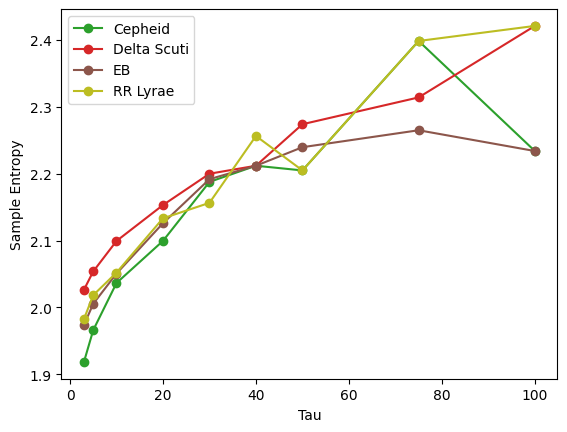

In [37]:
for i, c in enumerate(np.unique(filtered_classes)):
    
    idx = np.where(filtered_classes == c)[0]
    
    if c in ["Cepheid", "Delta Scuti", "EB", "RR Lyrae"]:

        m = np.median(filtered_entropies[idx, :], axis = 0)
        std = np.std(filtered_entropies[idx, :], axis = 0)

        time_scales = [3, 5, 10, 20, 30, 40, 50, 75, 100]
        plt.plot(time_scales, m, label=c, marker='o', color=f'C{i}')
        #plt.fill_between(time_scales, m-std, m+std, color=f'C{i}', alpha=0.1)

plt.xlabel('Tau')
plt.ylabel('Sample Entropy')

plt.legend()
plt.show()

In [38]:
for i, c in enumerate(np.unique(filtered_classes)):
    
    idx = np.where(filtered_classes == c)[0]
    
    if c in ["Cepheid", "Delta Scuti", "EB", "RR Lyrae"]:

        print(c,'-', np.median(filtered_lc_lengths[idx]), 'days')
        

Cepheid - 881.2538999999961 days
Delta Scuti - 185.62829999999667 days
EB - 890.6859000000004 days
RR Lyrae - 182.79389999999694 days


In [39]:
for i, c in enumerate(np.unique(filtered_classes)):
    
    idx = np.where(filtered_classes == c)[0]
    
    if c in ["Cepheid", "Delta Scuti", "EB", "RR Lyrae"]:

        print(c,'-', np.median(filtered_n_detection[idx]), 'detections')
        

Cepheid - 61.5 detections
Delta Scuti - 63.0 detections
EB - 82.0 detections
RR Lyrae - 72.0 detections


In [40]:
filtered_entropies.shape

(17573, 9)

In [41]:
reducer = UMAP(random_state=42, densmap=True)
embedding = reducer.fit_transform(filtered_entropies)
embedding.shape

/Users/vedshah/anaconda3/envs/multi-scale-entropy/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/vedshah/anaconda3/envs/multi-scale-entropy/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


(17573, 2)

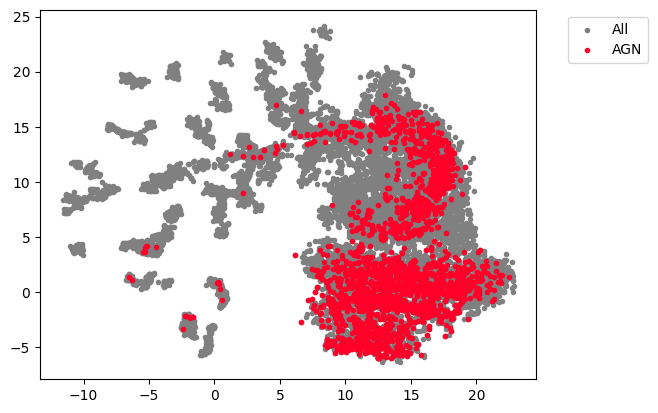

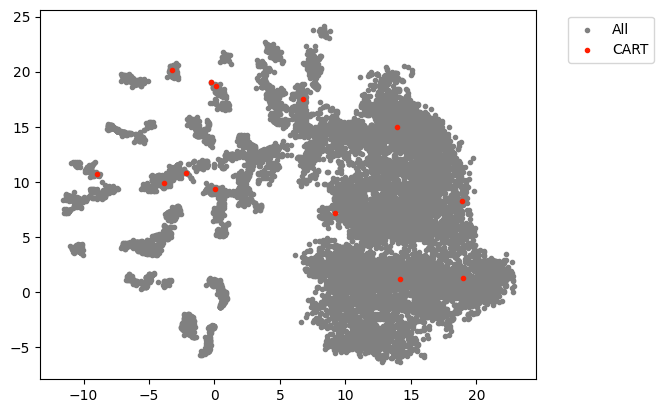

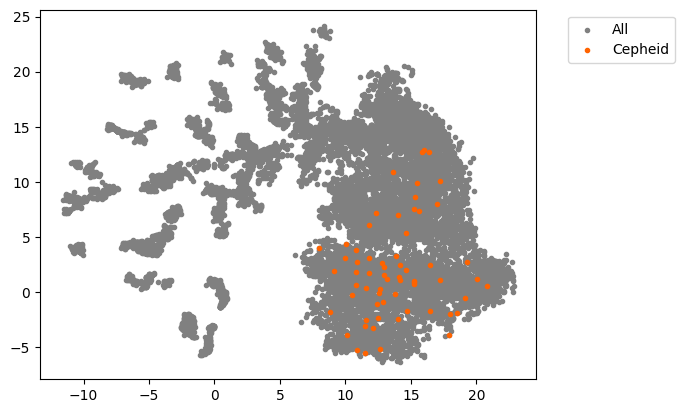

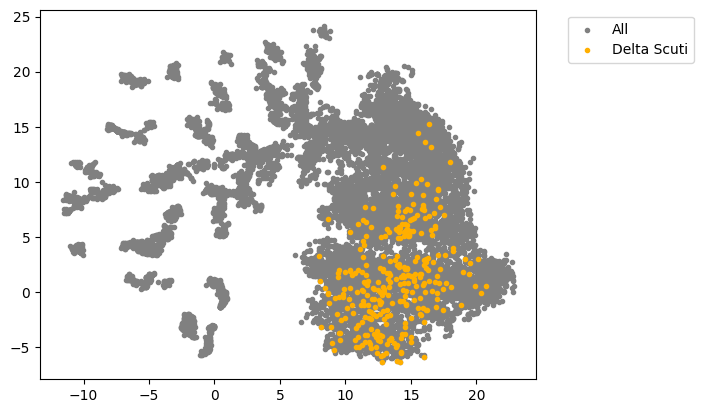

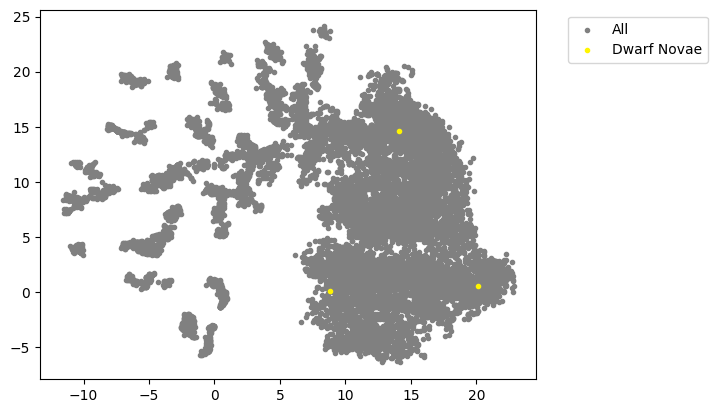

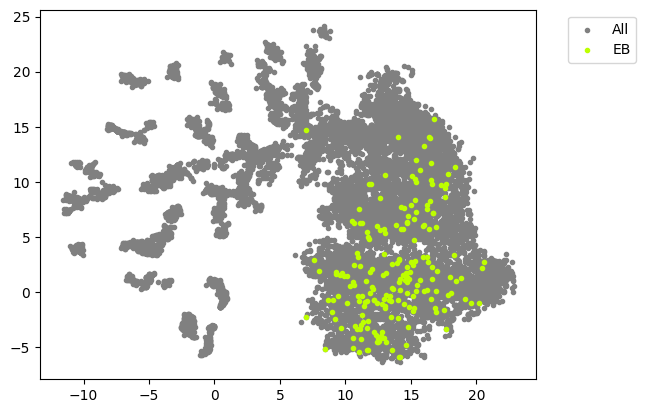

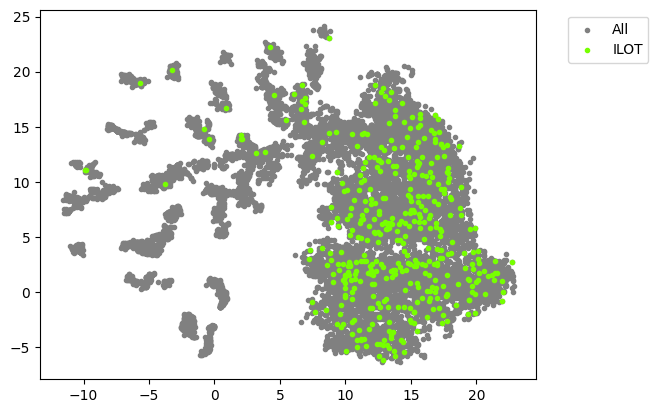

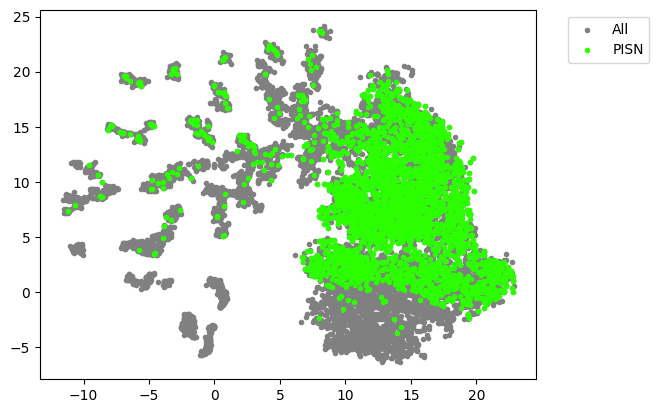

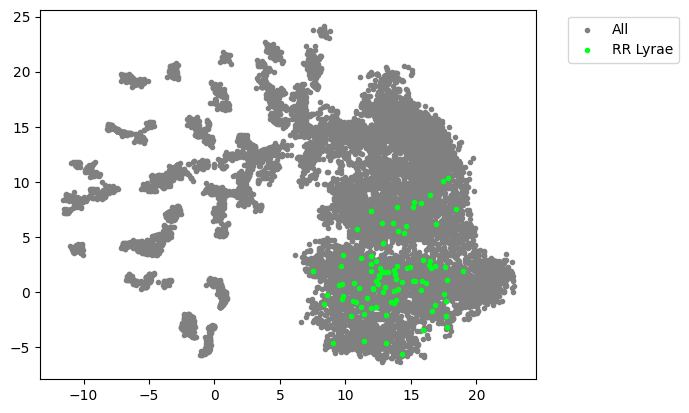

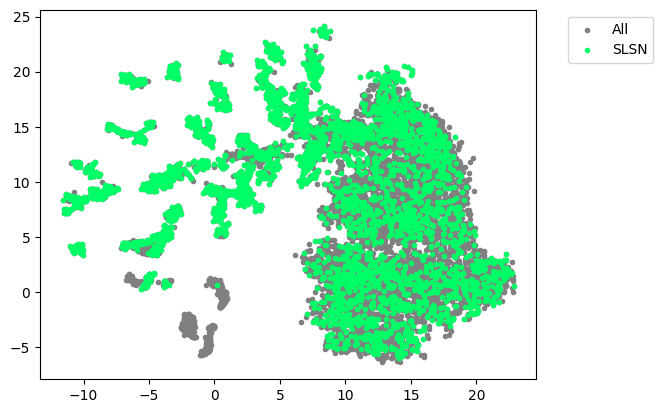

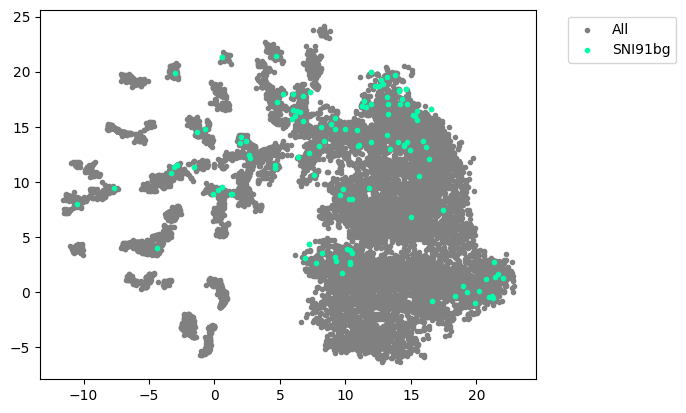

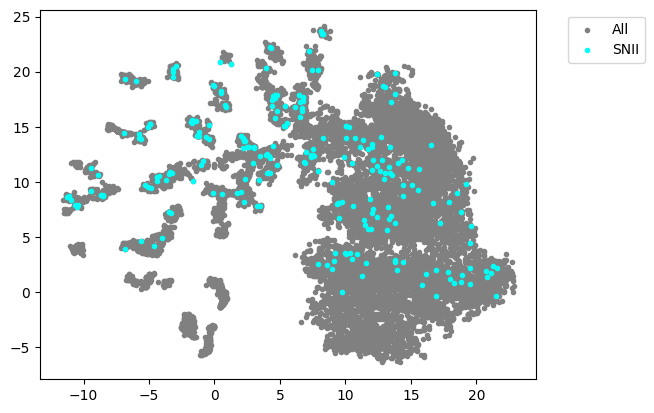

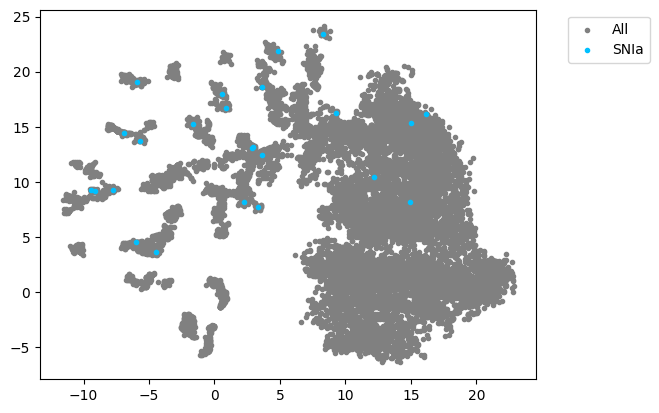

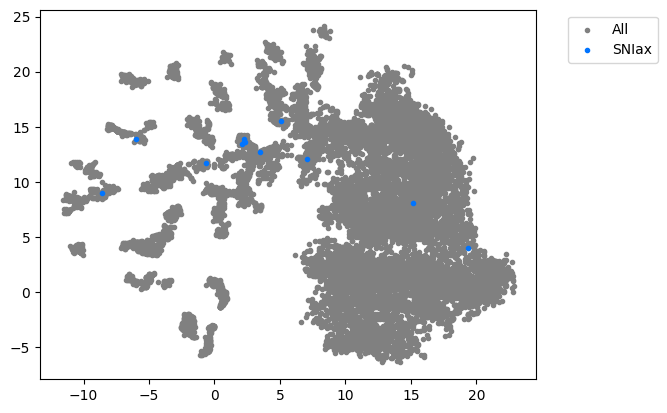

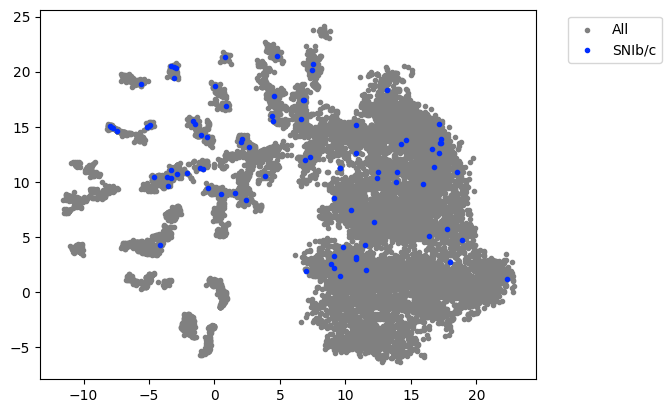

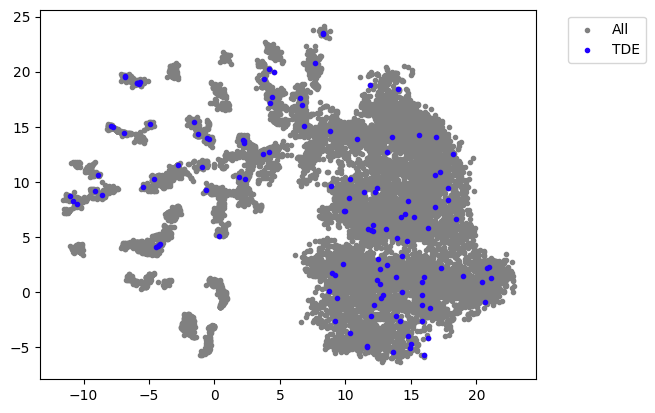

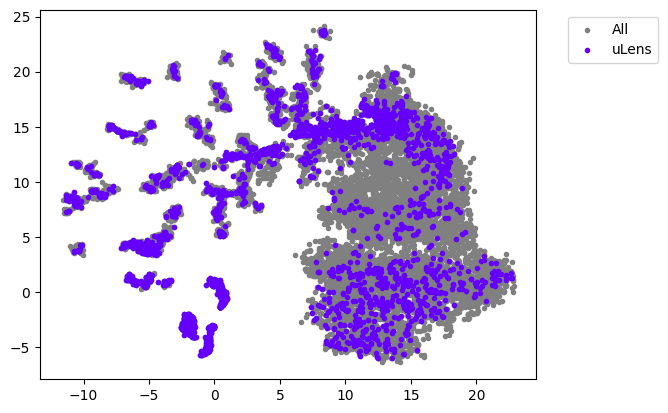

In [42]:

for i, c in enumerate(np.unique(filtered_classes)):
    idx = np.where(filtered_classes == c)[0]
    plt.scatter(embedding[:, 0], embedding[:, 1], label="All", marker='.', color='gray')
    plt.scatter(embedding[idx, 0], embedding[idx, 1], label=c, marker='.', color=color_arr[i])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

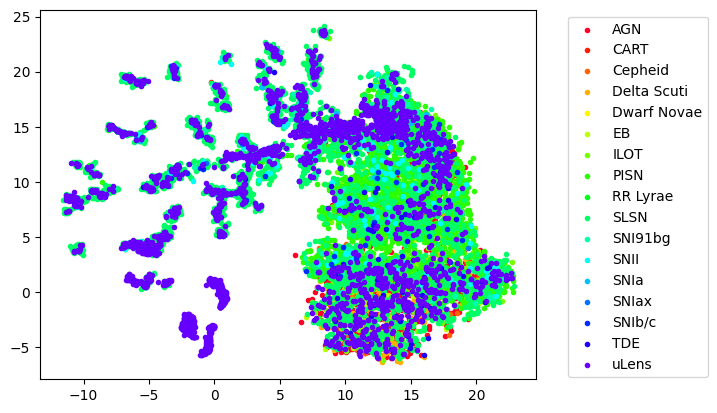

In [43]:
for i, c in enumerate(np.unique(filtered_classes)):
    idx = np.where(filtered_classes == c)[0]
    plt.scatter(embedding[idx, 0], embedding[idx, 1], label=c, marker='.', color=color_arr[i])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


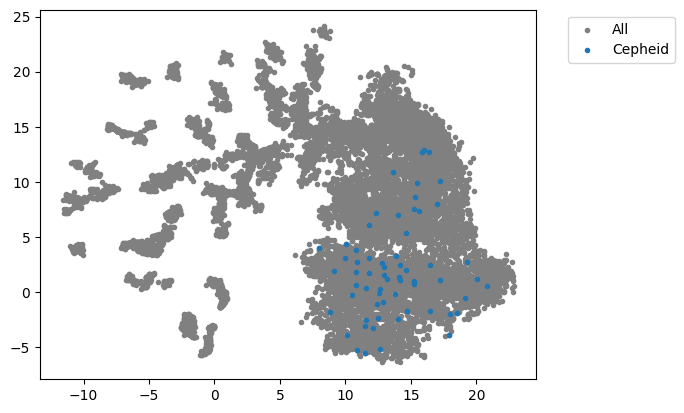

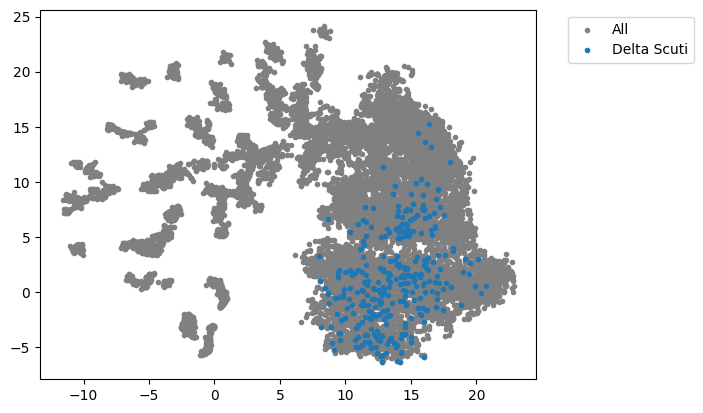

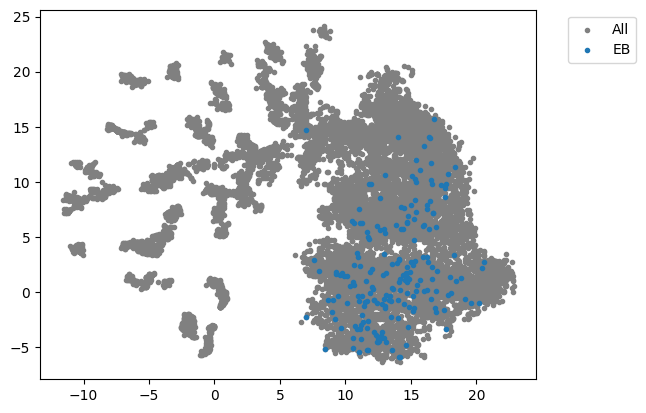

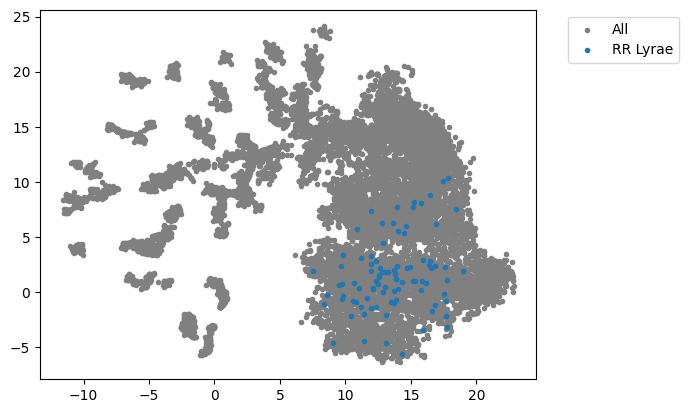

In [44]:
for c in np.unique(filtered_classes):
    idx = np.where(filtered_classes == c)[0]
    if c in ["Cepheid", "Delta Scuti", "EB", "RR Lyrae"]:
        plt.scatter(embedding[:, 0], embedding[:, 1], label="All", marker='.', color='gray')
        plt.scatter(embedding[idx, 0], embedding[idx, 1], label=c, marker='.')

        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

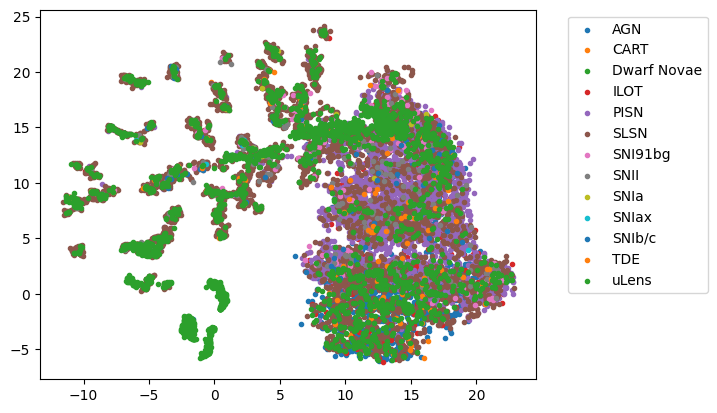

In [45]:
for c in np.unique(filtered_classes):
    idx = np.where(filtered_classes == c)[0]
    if c not in ["Cepheid", "Delta Scuti", "EB", "RR Lyrae"]:
        plt.scatter(embedding[idx, 0], embedding[idx, 1], label=c, marker='.')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

[-10.0, 20.0, -10.0, 20.0, -10.0, 20.0, -10.0, 20.0, -10.0, 20.0, -10.0, 20.0]

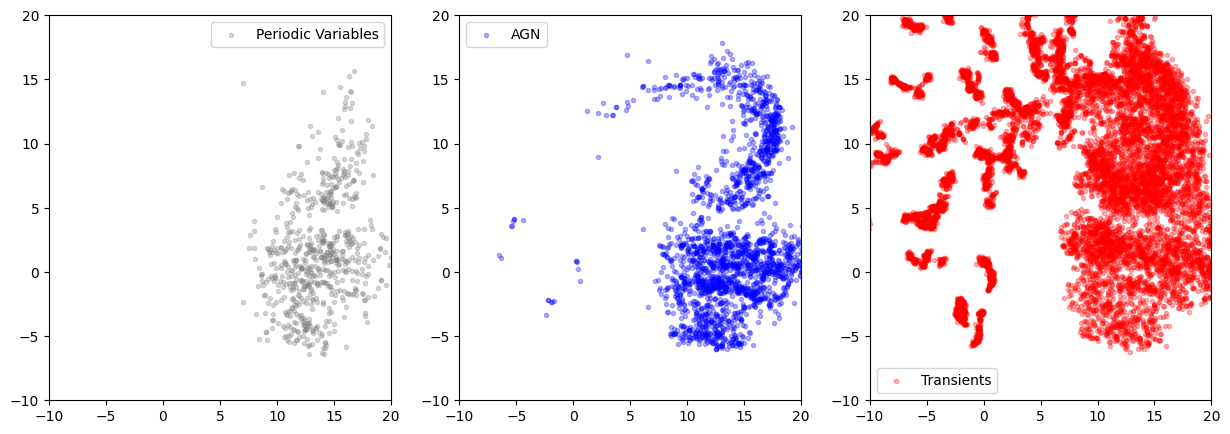

In [46]:
variables = []
agns = []
transients = []

for c in np.unique(filtered_classes):

    idx = np.where(filtered_classes == c)[0]
    if c in ["Cepheid", "Delta Scuti", "EB", "RR Lyrae"]:
        variables.append(embedding[idx, :])
        #axes[0].scatter(embedding[idx, 0], embedding[idx, 1], label="Periodic Variables", marker='.', color="gray", alpha=0.3)
    elif c == "AGN":
        agns.append(embedding[idx, :])
        #axes[1].scatter(embedding[idx, 0], embedding[idx, 1], label="AGN", marker='.', color="blue", alpha=0.3)
    else:
        transients.append(embedding[idx, :])
        #axes[2].scatter(embedding[idx, 0], embedding[idx, 1], label="Transients", marker='.', color="red", alpha=0.3)


variables = np.concatenate(variables)
agns = np.concatenate(agns)
transients = np.concatenate(transients)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))


axes[0].scatter(variables[:, 0], variables[:, 1], label="Periodic Variables", marker='.', color="gray", alpha=0.3)
axes[1].scatter(agns[:, 0], agns[:, 1], label="AGN", marker='.', color="blue", alpha=0.3)
axes[2].scatter(transients[:, 0], transients[:, 1], label="Transients", marker='.', color="red", alpha=0.3)

axes[0].legend()
axes[1].legend()
axes[2].legend()

# Defining custom 'xlim' and 'ylim' values.
custom_xlim = (-10, 20)
custom_ylim = (-10, 20)

# Setting the values for all axes.
plt.setp(axes, xlim=custom_xlim, ylim=custom_ylim)